In [1]:
import pickle
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_auc_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import KFold, StratifiedKFold
from scipy.stats.mstats import gmean
import xgboost as xgb
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
fpath = "/Users/ys8mz/Box Sync/Predictive Models of College Completion (VCCS)/intermediate_files"

In [15]:
df = pd.read_stata(fpath + "/full_data_truncated.dta")

In [16]:
predictors = pickle.load(open(fpath + "/lasso_selected_predictors.p", "rb"))
print(len(predictors))

147


In [17]:
impute_list_1 = set(["prop_comp_pre","cum_gpa_pre"])
impute_list_2 = set([t1+"_"+t2+str(t3) for t1 in ["term_gpa", "prop_comp", "lvl2_prop_comp", "dev_prop_comp"] for t2 in ["fa", "sp", "su"] for t3 in range(1,7,1)])
impute_list_3 = set(["cum_gpa", "lvl2_prop_comp", "dev_prop_comp", "prop_comp", "prop_comp_sd", "withdrawn_prop_comp_sd"])
impute_list_4 = set(["admrate", "gradrate", "satvr25", "satvr75", "satmt25", "satmt75", "satwr25", "satwr75"])

In [18]:
train_df = df[df.valid == 0]
test_df = df[df.valid == 1]
print(train_df.shape,test_df.shape)

(298139, 341) (33115, 341)


In [35]:
def impute(train, test):
    for p in impute_list_1:
        avg_p = np.nanmean(train[train.enrolled_pre == 1][p])
        train.loc[:,p] = train.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
        test.loc[:,p] = test.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
    for p in impute_list_3:
        avg_p = np.nanmean(train[p])
        train.loc[:,p] = train.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
        test.loc[:,p] = test.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
    for p in impute_list_2:
        suffix = p[-3:]
        avg_p = np.nanmean(train[train["enrolled_" + suffix] == 1][p])
        train.loc[:,p] = train.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
        test.loc[:,p] = test.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
    for p in impute_list_4:
        avg_p = np.nanmean(train[train["enrolled_nsc"] == 1][p])
        train.loc[:,p] = train.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
        test.loc[:,p] = test.loc[:,p].apply(lambda x: avg_p if pd.isnull(x) else x)
    return train, test 

In [36]:
train_df_new, test_df_new = impute(train_df, test_df)
X_train = train_df_new.loc[:,predictors]
y_train = train_df_new.grad_6years
X_test = test_df_new.loc[:,predictors]
y_test = test_df_new.grad_6years

C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [37]:
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

In [38]:
np.random.seed(4321)
val_indices = np.random.choice(train_df.shape[0], int(np.floor(train_df.shape[0]*0.15)), replace=False)
train_val = train_df.iloc[val_indices,:]
train_train = train_df.iloc[np.setdiff1d(np.arange(train_df.shape[0]), val_indices),:]
train_train_new, train_val_new = impute(train_train, train_val)
X_train_train = train_train_new.loc[:,predictors]
y_train_train = train_train_new.grad_6years
X_train_val = train_val_new.loc[:,predictors]
y_train_val = train_val_new.grad_6years

C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [39]:
dtrain_train = xgb.DMatrix(X_train_train, y_train_train)
dtrain_val = xgb.DMatrix(X_train_val, y_train_val)

In [4]:
results_dir = "C:\\Users\\ys8mz\\Box Sync\\Predictive Models of College Completion (VCCS)\\evaluation_results\\truncated_predictors\\"

#### (1) Grid Search for max_depth and eta (learning rate)

In [13]:
grid_1 = [(md,e) for md in range(4,8) for e in [0.01, 0.02, 0.05, 0.1, 0.2]]
validation_auc_1 = Counter()
for md,e in grid_1:
    print("max_depth = {0}, eta = {1}:".format(md,e))
    params = {'max_depth': md, 'eta': e, 'min_child_weight': 1, 'colsample_bytree': 0.8, 
              'subsample': 0.8, 
              'objective': 'binary:logistic', 'eval_metric': ['auc'],
              'seed': 12345}
    evals_result = {}
    xgb_model = xgb.train(params = params, dtrain = dtrain_train, num_boost_round = int(5e3), evals = [(dtrain_val, 'validation')],
                          early_stopping_rounds = 10,
                          evals_result = evals_result,
                          verbose_eval = 50)
    validation_auc_1[(md,e)] = np.max(evals_result['validation']['auc'])
    print("")

max_depth = 4, eta = 0.01:
[0]	validation-auc:0.818826
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.849457
[100]	validation-auc:0.855255
[150]	validation-auc:0.860315
[200]	validation-auc:0.864562
[250]	validation-auc:0.86797
[300]	validation-auc:0.870685
[350]	validation-auc:0.873008
[400]	validation-auc:0.874938
[450]	validation-auc:0.876465
[500]	validation-auc:0.87775
[550]	validation-auc:0.878948
[600]	validation-auc:0.879867
[650]	validation-auc:0.880784
[700]	validation-auc:0.88159
[750]	validation-auc:0.882313
[800]	validation-auc:0.883002
[850]	validation-auc:0.883603
[900]	validation-auc:0.884137
[950]	validation-auc:0.884665
[1000]	validation-auc:0.885149
[1050]	validation-auc:0.885596
[1100]	validation-auc:0.885982
[1150]	validation-auc:0.88633
[1200]	validation-auc:0.886652
[1250]	validation-auc:0.887046
[1300]	validation-auc:0.887377
[1350]	validation-auc:0.887657
[1400]	validation-auc:0.887948
[1450]	validation-auc:0.888209
[1500]	v

[2050]	validation-auc:0.893728
[2100]	validation-auc:0.893856
[2150]	validation-auc:0.893989
[2200]	validation-auc:0.894124
[2250]	validation-auc:0.894218
[2300]	validation-auc:0.894311
[2350]	validation-auc:0.894423
[2400]	validation-auc:0.894518
[2450]	validation-auc:0.894608
[2500]	validation-auc:0.894702
[2550]	validation-auc:0.894785
[2600]	validation-auc:0.894853
[2650]	validation-auc:0.894947
[2700]	validation-auc:0.895022
[2750]	validation-auc:0.895093
[2800]	validation-auc:0.895192
[2850]	validation-auc:0.895243
[2900]	validation-auc:0.895302
[2950]	validation-auc:0.895374
[3000]	validation-auc:0.895437
[3050]	validation-auc:0.895499
[3100]	validation-auc:0.89557
[3150]	validation-auc:0.895634
[3200]	validation-auc:0.895701
[3250]	validation-auc:0.895761
[3300]	validation-auc:0.895827
[3350]	validation-auc:0.895888
[3400]	validation-auc:0.895941
[3450]	validation-auc:0.895999
[3500]	validation-auc:0.896058
[3550]	validation-auc:0.89611
[3600]	validation-auc:0.896145
[3650]	val

[400]	validation-auc:0.895265
[450]	validation-auc:0.895685
[500]	validation-auc:0.895983
[550]	validation-auc:0.89626
[600]	validation-auc:0.896469
[650]	validation-auc:0.896725
Stopping. Best iteration:
[679]	validation-auc:0.896814


max_depth = 6, eta = 0.1:
[0]	validation-auc:0.842283
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.885236
[100]	validation-auc:0.891113
[150]	validation-auc:0.893397
[200]	validation-auc:0.894604
[250]	validation-auc:0.895407
[300]	validation-auc:0.895856
[350]	validation-auc:0.896256
Stopping. Best iteration:
[362]	validation-auc:0.896328


max_depth = 6, eta = 0.2:
[0]	validation-auc:0.842283
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.890212
[100]	validation-auc:0.893367
[150]	validation-auc:0.89462
Stopping. Best iteration:
[187]	validation-auc:0.895


max_depth = 7, eta = 0.01:
[0]	validation-auc:0.848485
Will train until validation-auc hasn't improved in 10 rounds.
[50]

In [14]:
for t in validation_auc_1.most_common():
    print(t)

((7, 0.02), 0.897942)
((6, 0.02), 0.897741)
((7, 0.01), 0.897478)
((7, 0.05), 0.897228)
((5, 0.02), 0.897135)
((6, 0.01), 0.896815)
((6, 0.05), 0.896814)
((5, 0.01), 0.896717)
((6, 0.1), 0.896328)
((5, 0.05), 0.896242)
((7, 0.1), 0.896126)
((5, 0.1), 0.895846)
((4, 0.02), 0.895765)
((4, 0.05), 0.895265)
((4, 0.01), 0.895035)
((6, 0.2), 0.895)
((4, 0.2), 0.894785)
((5, 0.2), 0.894759)
((4, 0.1), 0.894574)
((7, 0.2), 0.893994)


#### (2) Grid Search for min_child_weight (along with max_depth)

In [15]:
md1 = 6
grid_2 = [(md1+i,mcw) for i in [-1,0,1] for mcw in [3,5]]
validation_auc_2 = Counter()
for md,mcw in grid_2:
    print("max_depth = {0}, min_child_weight = {1}:".format(md,mcw))
    params = {'max_depth': md, 'eta': 0.02, 'min_child_weight': mcw, 'colsample_bytree': 0.8, 
              'subsample': 0.8, 
              'objective': 'binary:logistic', 'eval_metric': ['auc'],
              'seed': 12345}
    evals_result = {}
    xgb_model = xgb.train(params = params, dtrain = dtrain_train, num_boost_round = int(5e3), evals = [(dtrain_val, 'validation')],
                          early_stopping_rounds = 10,
                          evals_result = evals_result,
                          verbose_eval = 50)
    validation_auc_2[(md,mcw)] = np.max(evals_result['validation']['auc'])
    print("")

max_depth = 5, min_child_weight = 3:
[0]	validation-auc:0.833321
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.863243
[100]	validation-auc:0.870963
[150]	validation-auc:0.875958
[200]	validation-auc:0.879629
[250]	validation-auc:0.882138
[300]	validation-auc:0.884173
[350]	validation-auc:0.885853
[400]	validation-auc:0.887122
[450]	validation-auc:0.888145
[500]	validation-auc:0.889021
[550]	validation-auc:0.889744
[600]	validation-auc:0.890389
[650]	validation-auc:0.891015
[700]	validation-auc:0.891523
[750]	validation-auc:0.891934
[800]	validation-auc:0.892359
[850]	validation-auc:0.892753
[900]	validation-auc:0.893102
[950]	validation-auc:0.893416
[1000]	validation-auc:0.89366
[1050]	validation-auc:0.89392
[1100]	validation-auc:0.894132
[1150]	validation-auc:0.894377
[1200]	validation-auc:0.894567
[1250]	validation-auc:0.894745
[1300]	validation-auc:0.894933
[1350]	validation-auc:0.895107
[1400]	validation-auc:0.895231
[1450]	validation-auc:0.895

In [16]:
for t in validation_auc_2.most_common():
    print(t)

((7, 5), 0.898061)
((7, 3), 0.897921)
((6, 5), 0.897595)
((5, 5), 0.89726)
((6, 3), 0.897207)
((5, 3), 0.896986)


#### (3) Grid Search for colsample_by_tree

In [17]:
grid_3 = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
validation_auc_3 = Counter()
for cbt in grid_3:
    print("colsample_by_tree = {}:".format(cbt))
    params = {'max_depth': 7, 'eta': 0.02, 'min_child_weight': 5, 'colsample_bytree': cbt, 
              'subsample': 0.8, 
              'objective': 'binary:logistic', 'eval_metric': ['auc'],
              'seed': 12345}
    evals_result = {}
    xgb_model = xgb.train(params = params, dtrain = dtrain_train, num_boost_round = int(5e3), evals = [(dtrain_val, 'validation')],
                          early_stopping_rounds = 10,
                          evals_result = evals_result,
                          verbose_eval = 50)
    validation_auc_3[cbt] = np.max(evals_result['validation']['auc'])
    print("")

colsample_by_tree = 0.5:
[0]	validation-auc:0.846843
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.876068
[100]	validation-auc:0.880324
[150]	validation-auc:0.883456
[200]	validation-auc:0.885971
[250]	validation-auc:0.888037
[300]	validation-auc:0.889711
[350]	validation-auc:0.891107
[400]	validation-auc:0.892095
[450]	validation-auc:0.892891
[500]	validation-auc:0.893535
[550]	validation-auc:0.89407
[600]	validation-auc:0.894554
[650]	validation-auc:0.894925
[700]	validation-auc:0.89527
[750]	validation-auc:0.895593
[800]	validation-auc:0.895875
[850]	validation-auc:0.896095
[900]	validation-auc:0.896314
[950]	validation-auc:0.896474
[1000]	validation-auc:0.896648
[1050]	validation-auc:0.896834
[1100]	validation-auc:0.896974
[1150]	validation-auc:0.897107
[1200]	validation-auc:0.897259
[1250]	validation-auc:0.897372
[1300]	validation-auc:0.897507
[1350]	validation-auc:0.897593
[1400]	validation-auc:0.897685
Stopping. Best iteration:
[1438]	valida

[1150]	validation-auc:0.897198
[1200]	validation-auc:0.897317
[1250]	validation-auc:0.897451
[1300]	validation-auc:0.897615
[1350]	validation-auc:0.897683
[1400]	validation-auc:0.897766
[1450]	validation-auc:0.897858
[1500]	validation-auc:0.897949
Stopping. Best iteration:
[1501]	validation-auc:0.897952


colsample_by_tree = 0.9:
[0]	validation-auc:0.849377
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.87314
[100]	validation-auc:0.879008
[150]	validation-auc:0.882833
[200]	validation-auc:0.885826
[250]	validation-auc:0.888076
[300]	validation-auc:0.889872
[350]	validation-auc:0.891255
[400]	validation-auc:0.892211
[450]	validation-auc:0.892982
[500]	validation-auc:0.893588
[550]	validation-auc:0.894167
[600]	validation-auc:0.894689
[650]	validation-auc:0.895059
[700]	validation-auc:0.895451
[750]	validation-auc:0.895745
[800]	validation-auc:0.896008
[850]	validation-auc:0.896228
[900]	validation-auc:0.896443
[950]	validation-auc:0.896646
[1000]	val

In [18]:
validation_auc_3.most_common()

[(0.75, 0.898344),
 (0.7, 0.898077),
 (0.8, 0.898061),
 (0.65, 0.897973),
 (0.85, 0.897952),
 (0.9, 0.897947),
 (0.55, 0.8979),
 (0.5, 0.897771),
 (0.6, 0.897125)]

#### (4) Finally select the opitmal num_boost_round

In [19]:
params = {'max_depth': 7, 'eta': 0.02, 'min_child_weight': 5, 'colsample_bytree': 0.75, 
          'subsample': 0.8, 
          'objective': 'binary:logistic', 'eval_metric': ['auc'],
          'seed': 12345}
evals_result = {}
xgb_model = xgb.train(params = params, dtrain = dtrain_train, num_boost_round = int(5e3), evals = [(dtrain_val, 'validation')],
                      early_stopping_rounds = 10,
                      evals_result = evals_result,
                      verbose_eval = 50)
optimal_num_boost_round = np.argmax(evals_result['validation']['auc'])
print("")
print(optimal_num_boost_round)

[0]	validation-auc:0.848839
Will train until validation-auc hasn't improved in 10 rounds.
[50]	validation-auc:0.874308
[100]	validation-auc:0.879491
[150]	validation-auc:0.883069
[200]	validation-auc:0.885974
[250]	validation-auc:0.888222
[300]	validation-auc:0.889934
[350]	validation-auc:0.891306
[400]	validation-auc:0.892324
[450]	validation-auc:0.893053
[500]	validation-auc:0.893763
[550]	validation-auc:0.894303
[600]	validation-auc:0.894765
[650]	validation-auc:0.895184
[700]	validation-auc:0.895519
[750]	validation-auc:0.89584
[800]	validation-auc:0.896099
[850]	validation-auc:0.896307
[900]	validation-auc:0.89654
[950]	validation-auc:0.896719
[1000]	validation-auc:0.896917
[1050]	validation-auc:0.897083
[1100]	validation-auc:0.897192
[1150]	validation-auc:0.897299
[1200]	validation-auc:0.897415
[1250]	validation-auc:0.897514
[1300]	validation-auc:0.897642
[1350]	validation-auc:0.897728
[1400]	validation-auc:0.897814
[1450]	validation-auc:0.897871
[1500]	validation-auc:0.897948
[1

#### (5) Train the final xgb model and make predictions for observations in the test set

In [17]:
optimal_num_boost_round = 1791

In [18]:
# specify parameters via map
params = {'max_depth': 7, 'eta': 0.02, 'min_child_weight': 5, 'colsample_bytree': 0.75, 
          'subsample': 0.8, 
          'objective': 'binary:logistic', 'eval_metric': ['auc'],
          'seed': 12345}
final_xgb_model = xgb.train(params = params, dtrain = dtrain, num_boost_round = optimal_num_boost_round)
# make prediction for observations in the test set
y_test_pred = final_xgb_model.predict(dtest)

In [19]:
print("XGBoost:")
print("AUC = {}".format(round(roc_auc_score(dtest.get_label(), y_test_pred), 4)))

XGBoost:
AUC = 0.9028


In [20]:
# save the model object and predicted scores on the validation sample to local disk
# pickle.dump(final_xgb_model, open(results_dir + "/reduced_xgb.p", "wb"))
pickle.dump(list(y_test_pred), open(results_dir + "/y_test_pred_xgb_reduced.p", "wb"))

In [23]:
feature_importance = pd.DataFrame(list(final_xgb_model.get_fscore().items()), columns=['feature','importance']).sort_values('importance', ascending=False)
feature_importance.loc[:, 'importance'] = feature_importance.loc[:, 'importance'] / sum(feature_importance.loc[:, 'importance'])
yy = feature_importance.loc[:, 'importance'].iloc[:20]
xx = feature_importance.loc[:, 'feature'].iloc[:20]

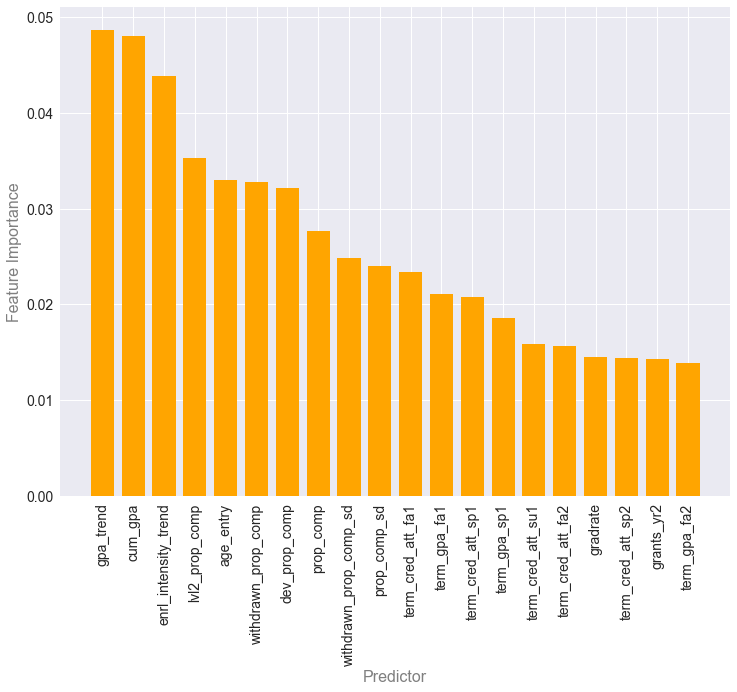

In [25]:
fig = plt.figure(figsize=(12,9))
plt.bar(list(range(20)), yy, width=0.75, color = "orange")
plt.xticks(list(range(20)), xx, rotation = 'vertical', fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Predictor", fontsize=16, color="gray")
plt.ylabel("Feature Importance", fontsize=16, color="gray")
plt.savefig(results_dir + "Reduced_XGBoost_variable_importance.png", bbox_inches='tight')
plt.show()

In [26]:
def find_optimal_threshold(p,r,t):
    to_drop = np.union1d(np.where(pd.isnull(p[:-1]) == True)[0], np.where(pd.isnull(r[:-1]) == True)[0])
    to_drop = np.union1d(to_drop, np.where(pd.isnull(t) == True)[0])
    to_keep = np.setdiff1d(np.array(list(range(len(p)-1))), to_drop)
    p,r,t = p[to_keep],r[to_keep],t[to_keep]
    f1 = 2*p*r/(p+r)
    best_t = t[np.argmax(f1)]
    best_t
    return best_t

def cross_validation(train, xgb_params, nbr):
    threshold_list = []
    auc_list = []
    k_fold =  StratifiedKFold(n_splits = 10, random_state = 12345, shuffle=True)
    for train_indices, test_indices in k_fold.split(train, train.grad_6years):
        train_part = train.iloc[train_indices,:]
        test_part = train.iloc[test_indices,:]
        train_part_new, test_part_new = impute(train_part, test_part)
        X_1 = train_part_new.loc[:,predictors]
        y_1 = train_part_new.grad_6years
        X_2 = test_part_new.loc[:,predictors]
        y_2 = test_part_new.grad_6years
        dtrain_cv = xgb.DMatrix(X_1,y_1)
        dtest_cv = xgb.DMatrix(X_2,y_2)
        xgb_cv_model = xgb.train(params=xgb_params, dtrain=dtrain_cv, num_boost_round = nbr)
        y_2_pred = xgb_cv_model.predict(dtest_cv)
        p,r,t = precision_recall_curve(y_2, y_2_pred)
        auc = roc_auc_score(y_2, y_2_pred)
        threshold_list.append(find_optimal_threshold(p,r,t))
        auc_list.append(auc)
    print(np.mean(auc_list), np.std(auc_list, ddof=1))
    return gmean(threshold_list)

In [ ]:
final_params = {'max_depth': 7, 'eta': 0.02, 'min_child_weight': 3, 'colsample_bytree': 0.75, 
                'subsample': 0.8, 
                'objective': 'binary:logistic', 'eval_metric': ['auc'],
                'seed': 12345}
best_threshold = cross_validation(train_df, final_params, optimal_num_boost_round)

C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\ys8mz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

0.9002395034795084 0.0017618763934114463


In [ ]:
best_threshold

0.3810536

In [25]:
def create_confusion_matrix(y_test_pred, threshold, fname):
    cm_arr = confusion_matrix(y_test, np.where(y_test_pred > threshold, 1, 0))
    cm_df = pd.DataFrame(cm_arr, columns=['Pred_0','Pred_1'], index=['Real_0', 'Real_1'])
    cm_df.loc[:,''] = cm_df.sum(axis=1)
    cm_df.loc['',:] = cm_df.sum(axis=0)
    print(cm_df)
    print("")
    p1 = cm_df.iloc[1,1]/cm_df.iloc[2,1]
    r1 = cm_df.iloc[1,1]/cm_df.iloc[1,2]
    p0 = cm_df.iloc[0,0]/cm_df.iloc[2,0]
    r0 = cm_df.iloc[0,0]/cm_df.iloc[0,2]    
    print("F1 score = {}".format(round(2*p1*r1/(p1+r1),4)))    
    cm_df.to_csv(results_dir + fname + ".csv")
    return p1,r1,p0,r0,round(2*p1*r1/(p1+r1),4)

In [1]:
print("F1 threshold = {}:\n".format(str(round(best_threshold,3))))
pr_xgb = create_confusion_matrix(np.array(y_test_pred), best_threshold, "Reduced_XGBoost_cm1")

In [ ]:
num_of_0 = int(round((1-np.mean(train_df.grad_6years))*len(y_test)))
y_test_pred_binary = np.ones(len(y_test))
y_test_pred_binary[np.argsort(y_test_pred)[:num_of_0]] = 0
alternative_threshold = y_test_pred[np.argsort(y_test_pred)[num_of_0]]
print("Alternative threshold = {}:\n".format(str(round(alternative_threshold,3))))
pr2_xgb = create_confusion_matrix(y_test_pred_binary, best_threshold, "Reduced_XGBoost_cm2")

Alternative threshold = 0.432:

         Pred_0   Pred_1         
Real_0  19203.0   2605.0  21808.0
Real_1   2586.0   8721.0  11307.0
        21789.0  11326.0  33115.0

F1 score = 0.7706


In [ ]:
precision_recall_df = pd.DataFrame([(best_threshold,)+pr_xgb,(alternative_threshold,)+pr2_xgb]).round(4)
precision_recall_df.index = ['F1','Same_Graduation_Rate']
precision_recall_df.columns = ['threshold','precision_1','recall_1','precision_0','recall_0','f1_score']
precision_recall_df.to_csv(results_dir + "Reduced_XGBoost_precision_recall.csv", index=True)

#### Reorganize files of key evaluation metrics for the five models with automatically selected predictors: OLS, Logit, RF, XGBoost, CoxPH

In [6]:
results_dir_new = "C:\\Users\\ys8mz\\Box Sync\\Predictive Models of College Completion (VCCS)\\evaluation_results\\reduced\\"

In [9]:
# Key evaluation metrics used to generate Appendix Figure A17 of the paper
cstat = [0.883, 0.8787, 0.8884, 0.9028, 0.8807]
m_dict = {'Logit': 'LR1', 'OLS': 'OLS',
          'RF': 'RF', 'XGBoost': 'XGBoost',
          'CoxPH': 'Cox'}
m_list = ['Logit', 'OLS', 'CoxPH', 'RF', 'XGBoost']
summary = []
for c,m in zip(cstat,m_list):
    summary.append((m,c)+tuple(pd.read_csv(results_dir + "\\reduced_{}_precision_recall.csv".format(m_dict[m])).iloc[0,1:]))
summary_df = pd.DataFrame(summary, columns=['model','c-statistic','threshold','precision_1','recall_1',
                                            'precision_0','recall_0','f1_score_1'])
summary_df.loc[:,'f1_score_0'] = (2*summary_df.precision_0*summary_df.recall_0/(summary_df.precision_0+summary_df.recall_0)).apply(lambda x: round(x,4))
summary_df.to_csv(results_dir_new + "cleaned_results\\main_eval_metrics.csv", index=False)